In [1]:
import seaborn as sns
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import torch
from torch import nn
import itertools
import shutil
import os, json, cv2, random, sys
from collections import defaultdict, Counter
from PIL import Image, ImageDraw, ImageFont

In [2]:
sys.path.append('../yolov5/')

In [3]:
torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

device(type='cuda', index=0)

In [22]:
# fine_tuned = torch.load('../yolov5/projects/COCO-street-from-scratch-2/exp/weights/best.pt')['model'].float().eval()
fine_tuned = torch.load('../yolov5/projects/COCO-street-finetune-6/exp/weights/best.pt')['model'].float().eval()
fine_tuned = fine_tuned.autoshape()

In [101]:
fine_tuned = fine_tuned.autoshape()
fine_tuned.conf = 0.27
fine_tuned.iou = 0.45
fine_tuned.multi_label = False  # NMS multiple labels per box
fine_tuned.max_det = 20

In [121]:
all_files = '../data/'

In [125]:
dataset_dict = defaultdict(list)
for root, dirs, files in os.walk(all_files):
    files = [file for file in files if file.split('.')[-1].lower() in ('jpg', 'png', 'jpeg')]
    files = [os.path.join(root, file) for file in files]
    if len(files) == 0:
        continue
    root_name = root[len(all_files):]
    dataset_dict[root_name] = files

In [126]:
dict(map(lambda k: (k[0], len(k[1])), dataset_dict.items()))

{'Другие животные': 319,
 'must_be_dogs': 651,
 'Пустые': 381,
 'Только собака/разноцветный - короткий хвост': 173,
 'Только собака/светлый - длинный хвост': 207,
 'Только собака/разноцветный - длинный хвост': 146,
 'Только собака/темный - короткий хвост': 225,
 'Только собака/светлый - короткой хвост': 256,
 'Только собака/темный - длинный хвост': 166,
 'must_not_be_dogs': 64,
 'Хозяин и собака': 520,
 'must_not_be_dogs_2': 68}

In [87]:
check_dogs = dataset_dict['Хозяин и собака']
check_dogs[:5]

['../data/Хозяин и собака/530.jpg',
 '../data/Хозяин и собака/2009.jpg',
 '../data/Хозяин и собака/495.jpg',
 '../data/Хозяин и собака/575.jpg',
 '../data/Хозяин и собака/2016.jpg']

In [88]:
def images_iterator(images: list):
    for im_path in images:
        nd_array = cv2.imread(im_path)
        if nd_array is not None:
            yield im_path, cv2.cvtColor(nd_array, cv2.COLOR_BGR2RGB)

In [95]:
found_results = []
for im_path, image in images_iterator(check_dogs):
    inf_res = fine_tuned(image)
    inf_res.print()
    res_df = inf_res.pandas().xyxy[0]
    res_df['im_path'] = im_path
#     res_df = res_df.query("name=='dog' or name=='person'")
#     if len(res_df.query("name=='dog'")) > 0 and len(res_df.query("name=='person'")) > 0:
#     res_df = res_df.query("name=='dog'")
    if len(res_df.query("name=='dog'")) > 0:
        found_results.append(res_df)

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


In [96]:
def show_image_with_regions(df, color=(128, 128, 128), txt_color=(255, 255, 255)):
    im_path = str(df['im_path'].values[0])
    nd_array = cv2.imread(im_path)
    nd_array = cv2.cvtColor(nd_array, cv2.COLOR_BGR2RGB)
    
    lw = max(round(sum(nd_array.shape) / 2 * 0.003), 2)
    tf = max(lw - 1, 1)  # font thickness
    
    for i, row in df.iterrows():
        label = row['name'] + ' ' + str(round(row['confidence'], 3))
        
        sp = (int(row['xmin']), int(row['ymin']))
        ep = (int(row['xmax']), int(row['ymax']))
        print(sp, ep)
        
        cv2.rectangle(nd_array, sp, ep, color, thickness=lw, lineType=cv2.LINE_AA)
        
        w, h = cv2.getTextSize(label, 0, fontScale=lw / 3, thickness=tf)[0]  # text width, height
        outside = sp[1] - h - 3 >= 0  # label fits outside box
        
        ep = sp[0] + w, sp[1] - h - 3 if outside else sp[1] + h + 3
        cv2.rectangle(nd_array, sp, ep, color, -1, cv2.LINE_AA)
        cv2.putText(nd_array, label, (sp[0], sp[1] - 2 if outside else sp[1] + h + 2), 0, lw / 3, txt_color,
                        thickness=tf, lineType=cv2.LINE_AA)
        
    
    plt.figure(figsize = (20,20))
    plt.imshow(np.squeeze(nd_array))
    plt.show()

In [97]:
len(found_results)

405

(193, 495) (252, 668)
(771, 507) (838, 659)
(601, 602) (690, 667)
(601, 599) (691, 668)


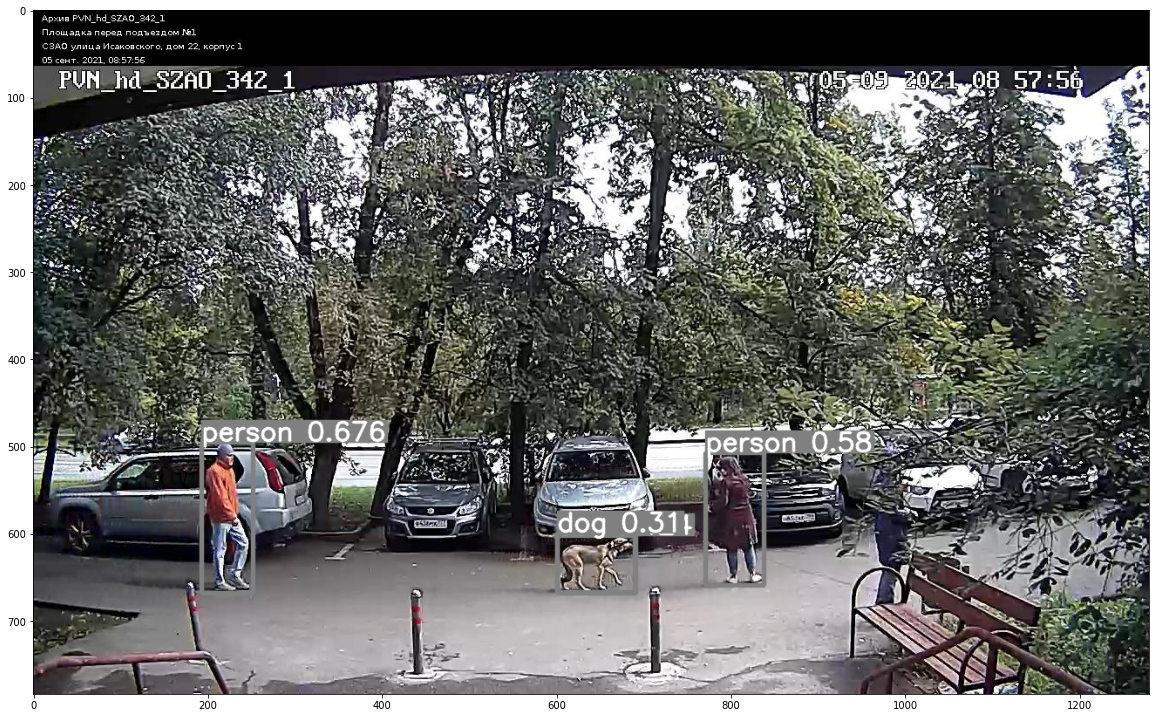

In [98]:
%matplotlib inline 
show_image_with_regions(found_results[17])

In [108]:
!pwd

/home/hivaze/CODE-W/PyCharm/lct_hack/notebooks


In [106]:
!cd "../data/Только\ собака/"

In [128]:
!python ../yolov5/detect.py --weights "../yolov5/projects/COCO-street-finetune-6/exp/weights/best.pt" --source "../data/Хозяин и собака" --save-txt --conf-thres 0.27 --save-crop --hide-labels --hide-conf

detect: weights=['../yolov5/projects/COCO-street-finetune-6/exp/weights/best.pt'], source=../data/Хозяин и собака, imgsz=[640, 640], conf_thres=0.27, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=True, save_conf=False, save_crop=True, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=../yolov5/runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=True, hide_conf=True, half=False, dnn=False
YOLOv5 🚀 v6.0-13-gfc36064 torch 1.9.1+cu102 CUDA:0 (GeForce RTX 2060, 5934.5625MB)

Fusing layers... 
Model Summary: 367 layers, 46533693 parameters, 0 gradients, 109.1 GFLOPs
image 1/516 /home/hivaze/CODE-W/PyCharm/lct_hack/data/Хозяин и собака/123.jpg: 416x640 1 person, 1 dog, Done. (0.038s)
image 2/516 /home/hivaze/CODE-W/PyCharm/lct_hack/data/Хозяин и собака/125.jpg: 416x640 1 person, 1 dog, Done. (0.029s)
image 3/516 /home/hivaze/CODE-W/PyCharm/lct_hack/data/Хозяин и собака/132.jpg: 416x640 1 person, 1 dog, Done

image 64/516 /home/hivaze/CODE-W/PyCharm/lct_hack/data/Хозяин и собака/2036 .jpg: 416x640 2 persons, 1 dog, Done. (0.024s)
image 65/516 /home/hivaze/CODE-W/PyCharm/lct_hack/data/Хозяин и собака/2037.jpg: 416x640 1 person, 1 dog, Done. (0.023s)
image 66/516 /home/hivaze/CODE-W/PyCharm/lct_hack/data/Хозяин и собака/2038.jpg: 416x640 5 persons, 1 dog, Done. (0.024s)
image 67/516 /home/hivaze/CODE-W/PyCharm/lct_hack/data/Хозяин и собака/2039.jpg: 416x640 1 person, 1 dog, Done. (0.026s)
image 68/516 /home/hivaze/CODE-W/PyCharm/lct_hack/data/Хозяин и собака/2040.jpg: 416x640 3 persons, 1 dog, Done. (0.026s)
image 69/516 /home/hivaze/CODE-W/PyCharm/lct_hack/data/Хозяин и собака/2041.jpg: 416x640 1 person, 1 dog, Done. (0.024s)
image 70/516 /home/hivaze/CODE-W/PyCharm/lct_hack/data/Хозяин и собака/2042.jpg: 416x640 1 person, 1 dog, Done. (0.023s)
image 71/516 /home/hivaze/CODE-W/PyCharm/lct_hack/data/Хозяин и собака/2043.jpg: 416x640 1 person, 1 dog, Done. (0.023s)
image 72/516 /home/hivaze/CO

image 132/516 /home/hivaze/CODE-W/PyCharm/lct_hack/data/Хозяин и собака/2139.jpg: 416x640 3 persons, 1 dog, Done. (0.024s)
image 133/516 /home/hivaze/CODE-W/PyCharm/lct_hack/data/Хозяин и собака/2140.jpg: 416x640 1 person, 1 dog, Done. (0.024s)
image 134/516 /home/hivaze/CODE-W/PyCharm/lct_hack/data/Хозяин и собака/216.jpg: 416x640 1 person, 2 dogs, Done. (0.023s)
image 135/516 /home/hivaze/CODE-W/PyCharm/lct_hack/data/Хозяин и собака/217.jpg: 416x640 1 person, 1 dog, Done. (0.023s)
image 136/516 /home/hivaze/CODE-W/PyCharm/lct_hack/data/Хозяин и собака/219.jpg: 416x640 1 person, 1 dog, Done. (0.023s)
image 137/516 /home/hivaze/CODE-W/PyCharm/lct_hack/data/Хозяин и собака/2202.jpg: 416x640 1 person, 2 dogs, Done. (0.026s)
image 138/516 /home/hivaze/CODE-W/PyCharm/lct_hack/data/Хозяин и собака/2203.jpg: 416x640 1 person, 2 dogs, Done. (0.026s)
image 139/516 /home/hivaze/CODE-W/PyCharm/lct_hack/data/Хозяин и собака/2204.jpg: 512x640 1 person, 1 dog, Done. (0.027s)
image 140/516 /home/hiv

image 200/516 /home/hivaze/CODE-W/PyCharm/lct_hack/data/Хозяин и собака/298.jpg: 416x640 1 person, 1 dog, Done. (0.024s)
image 201/516 /home/hivaze/CODE-W/PyCharm/lct_hack/data/Хозяин и собака/299.jpg: 416x640 1 person, 1 dog, Done. (0.024s)
image 202/516 /home/hivaze/CODE-W/PyCharm/lct_hack/data/Хозяин и собака/301.jpg: 416x640 1 person, 1 dog, Done. (0.025s)
image 203/516 /home/hivaze/CODE-W/PyCharm/lct_hack/data/Хозяин и собака/303.jpg: 416x640 1 person, 2 dogs, Done. (0.026s)
image 204/516 /home/hivaze/CODE-W/PyCharm/lct_hack/data/Хозяин и собака/304.jpg: 416x640 2 persons, 1 dog, Done. (0.025s)
image 205/516 /home/hivaze/CODE-W/PyCharm/lct_hack/data/Хозяин и собака/305.jpg: 416x640 1 person, 1 cat, 1 dog, Done. (0.026s)
image 206/516 /home/hivaze/CODE-W/PyCharm/lct_hack/data/Хозяин и собака/307.jpg: 416x640 2 persons, 2 dogs, Done. (0.026s)
image 207/516 /home/hivaze/CODE-W/PyCharm/lct_hack/data/Хозяин и собака/309.jpg: 416x640 1 person, 1 dog, Done. (0.025s)
image 208/516 /home/h

image 268/516 /home/hivaze/CODE-W/PyCharm/lct_hack/data/Хозяин и собака/461.jpg: 416x640 1 person, 2 dogs, Done. (0.024s)
image 269/516 /home/hivaze/CODE-W/PyCharm/lct_hack/data/Хозяин и собака/462.jpg: 416x640 1 person, 1 dog, Done. (0.024s)
image 270/516 /home/hivaze/CODE-W/PyCharm/lct_hack/data/Хозяин и собака/463.jpg: 416x640 1 person, 1 dog, Done. (0.024s)
image 271/516 /home/hivaze/CODE-W/PyCharm/lct_hack/data/Хозяин и собака/467.jpg: 416x640 1 person, Done. (0.026s)
image 272/516 /home/hivaze/CODE-W/PyCharm/lct_hack/data/Хозяин и собака/470.jpg: 416x640 1 person, 1 dog, Done. (0.024s)
image 273/516 /home/hivaze/CODE-W/PyCharm/lct_hack/data/Хозяин и собака/472.jpg: 416x640 1 person, 1 dog, Done. (0.023s)
image 274/516 /home/hivaze/CODE-W/PyCharm/lct_hack/data/Хозяин и собака/473.jpg: 416x640 1 person, 1 dog, Done. (0.026s)
image 275/516 /home/hivaze/CODE-W/PyCharm/lct_hack/data/Хозяин и собака/474.jpg: 416x640 1 person, Done. (0.026s)
image 276/516 /home/hivaze/CODE-W/PyCharm/lct

image 336/516 /home/hivaze/CODE-W/PyCharm/lct_hack/data/Хозяин и собака/6000.jpg: 416x640 5 persons, 1 dog, Done. (0.024s)
image 337/516 /home/hivaze/CODE-W/PyCharm/lct_hack/data/Хозяин и собака/6002.jpg: 416x640 2 persons, 1 dog, Done. (0.025s)
image 338/516 /home/hivaze/CODE-W/PyCharm/lct_hack/data/Хозяин и собака/6005.jpg: 416x640 2 persons, 1 dog, 1 backpack, Done. (0.026s)
image 339/516 /home/hivaze/CODE-W/PyCharm/lct_hack/data/Хозяин и собака/6008.jpg: 416x640 4 persons, 1 dog, Done. (0.026s)
image 340/516 /home/hivaze/CODE-W/PyCharm/lct_hack/data/Хозяин и собака/6010.jpg: 416x640 2 persons, Done. (0.024s)
image 341/516 /home/hivaze/CODE-W/PyCharm/lct_hack/data/Хозяин и собака/6011.jpg: 416x640 3 persons, 1 dog, Done. (0.024s)
image 342/516 /home/hivaze/CODE-W/PyCharm/lct_hack/data/Хозяин и собака/6012.jpg: 416x640 2 persons, Done. (0.023s)
image 343/516 /home/hivaze/CODE-W/PyCharm/lct_hack/data/Хозяин и собака/6013.jpg: 416x640 2 persons, 1 dog, Done. (0.025s)
image 344/516 /hom

image 403/516 /home/hivaze/CODE-W/PyCharm/lct_hack/data/Хозяин и собака/6180.jpg: 416x640 1 person, Done. (0.024s)
image 404/516 /home/hivaze/CODE-W/PyCharm/lct_hack/data/Хозяин и собака/6183.jpg: 416x640 1 person, Done. (0.024s)
image 405/516 /home/hivaze/CODE-W/PyCharm/lct_hack/data/Хозяин и собака/6184.jpg: 416x640 1 person, 1 cat, Done. (0.023s)
image 406/516 /home/hivaze/CODE-W/PyCharm/lct_hack/data/Хозяин и собака/6186.jpg: 416x640 1 person, 1 dog, Done. (0.024s)
image 407/516 /home/hivaze/CODE-W/PyCharm/lct_hack/data/Хозяин и собака/6191.jpg: 416x640 1 person, 1 dog, Done. (0.024s)
image 408/516 /home/hivaze/CODE-W/PyCharm/lct_hack/data/Хозяин и собака/6193.jpg: 416x640 1 person, 1 cat, 1 dog, Done. (0.024s)
image 409/516 /home/hivaze/CODE-W/PyCharm/lct_hack/data/Хозяин и собака/6194.jpg: 416x640 1 person, 1 dog, Done. (0.025s)
image 410/516 /home/hivaze/CODE-W/PyCharm/lct_hack/data/Хозяин и собака/6195.jpg: 416x640 2 persons, Done. (0.026s)
image 411/516 /home/hivaze/CODE-W/PyC

image 470/516 /home/hivaze/CODE-W/PyCharm/lct_hack/data/Хозяин и собака/6362.jpg: 416x640 2 persons, 1 dog, Done. (0.026s)
image 471/516 /home/hivaze/CODE-W/PyCharm/lct_hack/data/Хозяин и собака/6363.jpg: 416x640 4 persons, 1 dog, Done. (0.024s)
image 472/516 /home/hivaze/CODE-W/PyCharm/lct_hack/data/Хозяин и собака/6369.jpg: 416x640 1 person, 2 dogs, Done. (0.025s)
image 473/516 /home/hivaze/CODE-W/PyCharm/lct_hack/data/Хозяин и собака/6370.jpg: 416x640 2 persons, 3 cats, Done. (0.025s)
image 474/516 /home/hivaze/CODE-W/PyCharm/lct_hack/data/Хозяин и собака/6371.jpg: 416x640 2 persons, 2 dogs, Done. (0.027s)
image 475/516 /home/hivaze/CODE-W/PyCharm/lct_hack/data/Хозяин и собака/6372.jpg: 416x640 1 person, 1 dog, Done. (0.027s)
image 476/516 /home/hivaze/CODE-W/PyCharm/lct_hack/data/Хозяин и собака/6373.jpg: 416x640 1 person, 1 dog, Done. (0.026s)
image 477/516 /home/hivaze/CODE-W/PyCharm/lct_hack/data/Хозяин и собака/6374.jpg: 416x640 2 persons, 1 dog, Done. (0.024s)
image 478/516 /h

In [14]:
# dataset_fixes_addition = list(set([res['im_path'][0] for res in found_results]))
# dataset_fixes_addition[:7]

['../data/Другие животные/2321.jpg',
 '../data/Другие животные/2337.jpg',
 '../data/Другие животные/6147.jpg',
 '../data/Другие животные/725.jpg',
 '../data/Другие животные/727.jpg',
 '../data/Другие животные/6493.jpg',
 '../data/Другие животные/726.jpg']

In [16]:
# to_fix_dir = '../data/must_not_be_dogs_2/'
# for file in dataset_fixes_addition:
#     fpath = os.path.join(to_fix_dir, str(random.randint(1001, 10000)) + '_' + os.path.relpath(file, '../data').split('/')[-1])
#     print(f'Copy {file} to {fpath}...')
#     shutil.copyfile(file, fpath)